In [2]:
###
###  Prepare data: extract, transform, load (ETL)
###
import h5py as h5
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
    
import os
import time
from datetime import datetime

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

LABLE_WIDTH = 1
X_FEATURE = 'x'  # Name of the input feature.

RATE = 8192

class GWInject():
    def _shift_noise(self, tag, A, shift):
        MAX=self.srate
        var = self.f[tag]

        NX = len(var) 
        X  = np.random.normal(0,1,(NX,self.srate))
        NN = NX

        swf = np.zeros(var.shape)
        for i in range(NX):
            a = int((np.random.random()-0.5)*shift)  ## shift left or right
            swf[i,max(0,a):min(MAX, MAX+a)] += A * np.roll(var[i], a)[max(0,a):min(MAX, MAX+a)]
            
        X = np.vstack( (X, (A * swf[:NX,:] + X) )       ).astype(np.float32)
        
        Y = [1,0]
        for i in range(NX-1):
            Y = np.vstack((Y,[1,0]))
        for i in range(NX):
            Y = np.vstack((Y,[0,1]))     

        return X, Y
    
    def _add_noise(self, tag, A):
        var = self.f[tag]
        NX = len(var) 
        X = np.random.normal(0,1,(NX,self.srate))
        X = np.vstack( (X,  (A * var[:NX,:] + X )   )  ).astype(np.float32)
        
        Y = [1,0]
        for i in range(NX-1):
            Y = np.vstack((Y,[1,0]))
        for i in range(NX):
            Y = np.vstack((Y,[0,1]))       
        
        return X, Y
    
    def __init__(self, fname, plot=0):
        self.fname = fname
        self.plot = plot
        self.f = h5.File(fname, "r")
        self.srate = self.f.attrs.get('srate')

    def __exit__(self):
        self.f.close()
        
    def get_train_set(self, A=1.0):
        return self._add_noise('/train_hp', A)
    
    def get_test_set(self, A=1.0):
        return self._add_noise('/test_hp', A)
    
    def get_val_set(self, A=1.0):
        return self._add_noise('/val_hp', A)

    def get_shifted_train_set(self, A=1.0, shift=0):
        return self._shift_noise('/train_hp', A, shift)

    def get_shifted_test_set(self, A=1.0, shift=0):
        return self._shift_noise('/test_hp', A, shift)
    
    def get_shifted_val_set(self, A=1.0, shift=0):
        return self._shift_noise('/val_hp', A, shift)

In [3]:
###
### Prepare NN model: small model
###
def model(x_, keep_prob, WIDTH):
    feature = tf.reshape(x_, [-1, WIDTH,1])

    args = {"padding":'valid', "activation":None,
            "kernel_initializer":tf.truncated_normal_initializer(), 
            "bias_initializer":tf.zeros_initializer()     }
    
    def convl(in_, F, K, D, S, PO, PS, act):
        out = tf.layers.conv1d( in_, filters=F, kernel_size=K, dilation_rate=D, strides=S, **args)
        out = tf.layers.max_pooling1d(out, pool_size=PO, strides=PS, padding='valid')
        return act(out)
        
    o1 = convl(feature, F=16, K=16, D=1, S=1, PO=4, PS=4, act=tf.nn.relu)
    o2 = convl(o1,      F=32, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    o3 = convl(o2,      F=64, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    
    dim = o3.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    o4 = tf.reshape(o3, [-1, fcnn])
    o4     = tf.layers.dense(o4, 64, activation=tf.nn.relu, name="fc")
    logits = tf.layers.dense(o4, 2, activation=None)
    return logits

In [ ]:
###
###  Construct TF graph
###
tf.reset_default_graph()
DIM   = 8192
LRATE = 1e-3
keep_prob = tf.placeholder(tf.float32)   ##  for dropout, not used.

x = tf.placeholder(tf.float32, [None,DIM])
y = tf.placeholder(tf.int32, [None,2])

logits = model(x, keep_prob, DIM)

# Compute predictions
with tf.name_scope('eval'):
    predict_prob = tf.reshape(tf.nn.softmax(tf.reduce_max(logits,axis=1), name="softmax_tensor"),[-1])
    predict_op = tf.reshape(tf.argmax(logits,axis=1),[-1])
with tf.name_scope('loss'):
    #loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=tf.argmax(tf.cast(y, dtype=tf.int32),1)))
    loss_op = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
        labels=tf.argmax(tf.cast(y, dtype=tf.int32),1))


with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(LRATE).minimize(loss_op)

_, accuracy    = tf.metrics.accuracy(labels=tf.argmax(tf.cast(y, dtype=tf.int32),1), predictions=predict_op  )
_, sensitivity = tf.metrics.recall(labels=tf.argmax(tf.cast(y, dtype=tf.int32),1), predictions=predict_op  )

_, false_positives = tf.metrics.false_positives(labels=tf.argmax(tf.cast(y, dtype=tf.int32),1), predictions=predict_op  )
_, false_negatives = tf.metrics.false_negatives(labels=tf.argmax(tf.cast(y, dtype=tf.int32),1), predictions=predict_op  )
_, true_positives = tf.metrics.true_positives(labels=tf.argmax(tf.cast(y, dtype=tf.int32),1), predictions=predict_op  )
#_, true_negatives = tf.metrics.true_negatives(labels=tf.argmax(tf.cast(y, dtype=tf.int32),1), predictions=predict_op  )
true_negatives = true_positives + false_negatives - false_positives
tf.summary.histogram('loss', loss_op)
tf.summary.scalar('loss', loss_op)
tf.summary.scalar('accuracy', accuracy)

In [ ]:
##
##  Training with fixed template ....
##
    
GWdata = GWInject("white_h_8192_dm2.h5")

BATCH = 128
EPOCHS = 100
MONITOR = 2

PATIENCE = 4
TOLERENCE = 1.e-7
###
ROOT_FOLDER = '/tmp/classifier-2'
saver = tf.train.Saver(max_to_keep=50)

TEST_LIST = [2.05, 2.0, 1.95, 1.9, 1.85, 1.8, 1.75, 1.7, 1.65, 1.6, 1.55, 1.5, 1.45, 1.4, 1.35, 1.3, 1.25, 1.2, 1.15, 1.1, 1.05, 1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]
TRAIN_A = [2, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5]

with tf.Session() as sess:
   
    merged = tf.summary.merge_all()   ## call merged to do every summary
    
    sess.run(tf.global_variables_initializer())

    for amp in TRAIN_A:
        ## summarize to a new folder
        train_writer = tf.summary.FileWriter("%s/train_%4.2f" % (ROOT_FOLDER, amp ) )
    
        sess.run(tf.local_variables_initializer())

        X_train, Y_train = GWdata.get_shifted_train_set(A=amp)
        X_val, Y_val = GWdata.get_shifted_val_set(A=amp)
        print("Trainning for A= %f , dataset size: %d"% (amp, len(X_train) ))

        patience = 0
        
        time0 = time.time()
        for e in range(EPOCHS):
            randomize = np.arange(len(X_train))
            np.random.shuffle(randomize)
            X_train = X_train[randomize]
            Y_train = Y_train[randomize]
            randomize = np.arange(len(X_val))
            np.random.shuffle(randomize)
            X_val = X_val[randomize]
            Y_val = Y_val[randomize]
            STEPS   = int(len(X_train) / BATCH) 
            for i in range(STEPS):
                xbatch = X_train[i*BATCH:(i+1)*BATCH, :]
                ybatch = Y_train[i*BATCH:(i+1)*BATCH, :]
                _, summary = sess.run( [optimizer, merged], feed_dict={ x:xbatch, y:ybatch }   ) 
                train_writer.add_summary(summary, global_step=e)
            ### evaluate    
            loss, acc, sen = sess.run( [loss_op, accuracy, sensitivity],   feed_dict={x:X_val, y:Y_val} )
            
            time1 = time.time()
            duration = time1 - time0
            time0 = time1
            speed = STEPS * BATCH *MONITOR / duration
            print('  Epoch: %3d, loss: %10.3e acc: %4.2g sen: %4.2f sec: %5.1f speed: %7.1f wf/sec' % (e, loss, acc, sen, duration, speed) )
 
            if loss <  TOLERENCE:
                if patience > PATIENCE: break
                patience += 1
            else:
                patience = 0
         
        save_path = saver.save(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, amp ) )
        print("Model saved at %s" % save_path)

In [ ]:
###
###  Testing... with shift
###
BATCH = 4096

with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test_hp')
    sess.run(tf.global_variables_initializer())
   
    plt.figure()
    for m in TRAIN_A:
        try:
            load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, m ) )
            print("Model restored from %s" % load_path )
        except: 
            continue

        gacc=[]
        gsen=[]
        
        for amp in TEST_LIST:
            sess.run(tf.local_variables_initializer())
            
            X_test, Y_test  = GWdata.get_shifted_test_set(A=amp, shift=2500)
            randomize = np.arange(len(X_test))
            np.random.shuffle(randomize)
            X_test = X_test[randomize]
            Y_test = Y_test[randomize]
            
            i=int(np.random.random()* int(len(X_test)/BATCH) )
            xbatch = X_test[i*BATCH:(i+1)*BATCH, :]
            ybatch = Y_test[i*BATCH:(i+1)*BATCH, :]

            acc, sen, ttp, ttn, tfp, tfn = sess.run([accuracy, sensitivity, true_positives, true_negatives, false_positives, false_negatives ], feed_dict={ x: xbatch, y: ybatch })
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " % (amp, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gsen, label="model:%f"%m)
    plt.title("Classifier - with shift")
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    plt.show()

INFO:tensorflow:Restoring parameters from /tmp/classifier-1/model_1.15.ckpt
Model restored from None
Test for A= 2.00 : Acc:     0.870, Sen:     0.758, TP/TN/FP/FN:   496   642    12   158 
Test for A= 1.95 : Acc:     0.856, Sen:     0.726, TP/TN/FP/FN:   475   644    10   179 
Test for A= 1.90 : Acc:     0.862, Sen:     0.752, TP/TN/FP/FN:   492   636    18   162 
Test for A= 1.85 : Acc:     0.862, Sen:     0.734, TP/TN/FP/FN:   480   647     7   174 
Test for A= 1.80 : Acc:     0.838, Sen:     0.703, TP/TN/FP/FN:   460   636    18   194 
Test for A= 1.75 : Acc:     0.832, Sen:     0.676, TP/TN/FP/FN:   442   646     8   212 
Test for A= 1.70 : Acc:     0.833, Sen:     0.694, TP/TN/FP/FN:   454   636    18   200 
Test for A= 1.65 : Acc:     0.817, Sen:     0.657, TP/TN/FP/FN:   430   639    15   224 
Test for A= 1.60 : Acc:     0.807, Sen:     0.636, TP/TN/FP/FN:   416   640    14   238 
Test for A= 1.55 : Acc:     0.804, Sen:     0.633, TP/TN/FP/FN:   414   637    17   240 
Test for 

Test for A= 1.65 : Acc:     0.852, Sen:     0.708, TP/TN/FP/FN:   463   651     3   191 


KeyboardInterrupt: 

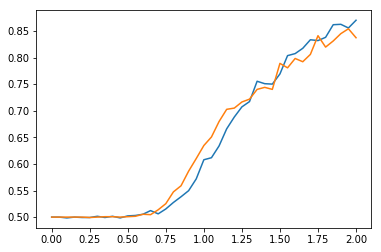

In [16]:
###
###  Testing... with shift
###
BATCH = 4096

with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test_hp')
    sess.run(tf.global_variables_initializer())
   
    plt.figure()
    for m in TRAIN_A:
        try:
            load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, m ) )
            print("Model restored from %s" % load_path )
        except: 
            continue

        gacc=[]
        gsen=[]
        
        for amp in TEST_LIST:
            sess.run(tf.local_variables_initializer())
            
            X_test, Y_test  = GWdata.get_shifted_test_set(A=amp, shift=2500)
            randomize = np.arange(len(X_test))
            np.random.shuffle(randomize)
            X_test = X_test[randomize]
            Y_test = Y_test[randomize]
            
            i=int(np.random.random()* int(len(X_test)/BATCH) )
            xbatch = X_test[i*BATCH:(i+1)*BATCH, :]
            ybatch = Y_test[i*BATCH:(i+1)*BATCH, :]

            acc, sen, ttp, ttn, tfp, tfn = sess.run([accuracy, sensitivity, true_positives, true_negatives, false_positives, false_negatives ], feed_dict={ x: xbatch, y: ybatch })
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " % (amp, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gacc, label="model:%f"%m)
    plt.title("Classifier - with shift")
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()